## Загрузим нужные библиотеки

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor

%matplotlib inline

## Описание входных значений
train/train_issues.csv — содержит в себе 9589 различных задач в спринте;
train/train_comments.csv — содержит комментарии разработчиков к задачам обучающего набора;
test/test_issues.csv — содержит в себе 1070 различных задач, для которых требуется предсказать потрачено команд;
train/test_comments.csv — содержит комментарии разработчиков к задачам тестового набора;
train/sample_solution.csv — пример файла для отправки;
employees.csv — cписок работников и их контактная информация

### Считаем тренировочный набор

In [2]:
df_issues_train = pd.read_csv("train_issues.csv")
df_comment_train = pd.read_csv("train_comments.csv")

df_emp = pd.read_csv("employees.csv")

## Рассмотрим датасет

In [3]:
df_issues_train.head(3)

,id,created,key,summary,project_id,assignee_id,creator_id,overall_worklogs
0,819952,2019-10-01 05:57:18.000,SM-10678,"UI тесты по заказу ""Добро КейДжи""",5,93,93,1800
1,819949,2019-10-01 05:59:45.000,SM-10679,"UI тесты раздела ""Профиль""",5,93,93,7200
2,819947,2019-10-01 06:00:38.000,SM-10680,"UI тесты раздела ""Личный счет""",5,93,93,14400


● id - идентификатор задачи в глобальной базе данных
● created - дата создания задачи
● key - ключ задачи, используется для идентификации задачи внутри проекта
● summary - описание задачи
● project_id - идентификатор проекта, по которому выполняется задача
● assignee_id - идентификатор сотрудника, на которого назначена задача (таблица сотрудников)
● creator_id - идентификатор сотрудника, который создал задачу (таблица сотрудников)
● overall_worklogs - количество времени в секундах, ушедшего на решение задачи

In [4]:
df_issues_train['assignee_creator'] = df_issues_train['assignee_id'] == df_issues_train['creator_id']

In [5]:
df_comment_train.head(3)

,comment_id,text,issue_id,author_id
0,11779,[https://www.youtube.com/watch?v=tuhOdtsvoNY|h...,669666,1
1,10601,OK [~accountid:557058:3f7ab89a-8969-4547-90df-...,669670,1
2,76101,I encountered a problem with access to `/users...,670930,2


● comment_id - идентификатор комментария
● text - текст комментария
● issue_id - идентификатор задачи (таблица задач)
● author_id - идентификатор автора комментария (таблица сотрудники)

### Посчитаем количество комментариев по каджой задаче

In [6]:
def count_comments(id_task):
    return df_comment_train[df_comment_train['issue_id'] == id_task].shape[0]

In [7]:
df_issues_train['count_comments'] = df_issues_train['id'].apply(count_comments)

In [8]:
df_issues_train.head(3)

,id,created,key,summary,project_id,assignee_id,creator_id,overall_worklogs,assignee_creator,count_comments
0,819952,2019-10-01 05:57:18.000,SM-10678,"UI тесты по заказу ""Добро КейДжи""",5,93,93,1800,True,0
1,819949,2019-10-01 05:59:45.000,SM-10679,"UI тесты раздела ""Профиль""",5,93,93,7200,True,1
2,819947,2019-10-01 06:00:38.000,SM-10680,"UI тесты раздела ""Личный счет""",5,93,93,14400,True,0


### Преобразование столбцов

Сделаем два столбца - день и месяц создания задачи

In [9]:
df_issues_train["mounth"] = df_issues_train.created.map(lambda x : int(x.split("-")[1]))
df_issues_train["day"] = df_issues_train.created.map(lambda x : int(x.split("-")[2].split()[0]))

### DataSet employees

In [10]:
df_emp.head(3)

,id,active,full_name,position,hiring_type,payment_type,salary_calculation_type,english_level,passport,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one
0,1,1,David Courtney,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
1,2,0,Dan Guerra,Web-разработчик,staff,fixed,NaN,NaN,0,0,0,0,0
2,4,0,Grady Smith,Web-разработчик,staff,fixed,NaN,NaN,0,0,0,0,0


Удалим ненужную информацию о работниках

In [11]:
df_emp = df_emp.drop(["active","full_name", "salary_calculation_type", "passport"],axis = 1)

Обьединим два набора данных по id исполнителя

In [12]:
df_train = pd.merge(df_issues_train, df_emp, left_on="assignee_id", right_on="id", how='inner')

In [13]:
df_train.shape

(9589, 21)

In [14]:
df_train.columns

Index(['id_x', 'created', 'key', 'summary', 'project_id', 'assignee_id',
       'creator_id', 'overall_worklogs', 'assignee_creator', 'count_comments',
       'mounth', 'day', 'id_y', 'position', 'hiring_type', 'payment_type',
       'english_level', 'is_nda_signed', 'is_labor_contract_signed',
       'is_added_to_internal_chats', 'is_added_one_to_one'],
      dtype='object')

In [15]:
df_train['hiring_type'].describe()

count      7630
unique        2
top       staff
freq       7005
Name: hiring_type, dtype: object

In [16]:
df_train['payment_type'].describe()

count      7529
unique        2
top       fixed
freq       5765
Name: payment_type, dtype: object

In [17]:
df_train = df_train.fillna(0)

Дубликаты

In [18]:
df_train[df_train.duplicated()].shape

(0, 21)

 Создадим список всех нечисловых лейблов и взглянем на них

In [19]:
mass_object = df_train.dtypes[df_train.dtypes == "object"].index.values

In [20]:
df_train[mass_object].head(3)

,created,key,summary,position,hiring_type,payment_type,english_level
0,2019-10-01 05:57:18.000,SM-10678,"UI тесты по заказу ""Добро КейДжи""",Разработчик мобильных приложений,staff,fixed,0
1,2019-10-01 05:59:45.000,SM-10679,"UI тесты раздела ""Профиль""",Разработчик мобильных приложений,staff,fixed,0
2,2019-10-01 06:00:38.000,SM-10680,"UI тесты раздела ""Личный счет""",Разработчик мобильных приложений,staff,fixed,0


Взглянем на них поближе

In [21]:
df_train.hiring_type.value_counts()

staff        7005
0            1959
non_staff     625
Name: hiring_type, dtype: int64

In [22]:
df_train.payment_type.value_counts()

fixed     5765
0         2060
hourly    1764
Name: payment_type, dtype: int64

In [23]:
df_train.english_level.value_counts()

0     9055
B1     358
C1     176
Name: english_level, dtype: int64

Сменим им тип данных

In [24]:
df_train["payment_type"] = pd.Categorical(df_train["payment_type"])
df_train["payment_type"].astype('category').cat.codes
df_train["payment_type"] = df_train["payment_type"].cat.codes

In [25]:
df_train["hiring_type"] = pd.Categorical(df_train["hiring_type"])
df_train["hiring_type"].astype('category').cat.codes
df_train["hiring_type"] = df_train["hiring_type"].cat.codes

In [26]:
df_train["english_level"] = pd.Categorical(df_train["english_level"])
df_train["english_level"].astype('category').cat.codes
df_train["english_level"] = df_train["english_level"].cat.codes

In [27]:
df_train['overall_worklogs'].describe()

count    9.589000e+03
mean     1.724369e+04
std      9.864197e+04
min      6.000000e+01
25%      3.000000e+03
50%      7.200000e+03
75%      1.470000e+04
max      7.014000e+06
Name: overall_worklogs, dtype: float64

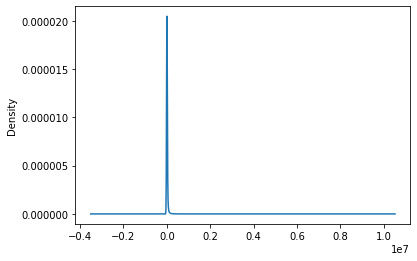

In [28]:
df_train['overall_worklogs'].plot.kde()

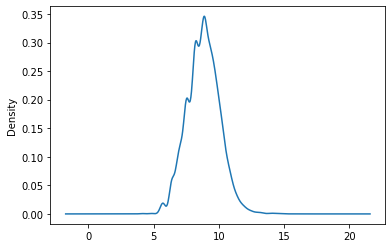

In [29]:
np.log(df_train['overall_worklogs']).plot.kde()

In [30]:
df_train.loc[(df_train['overall_worklogs'] > 7000000), 'overall_worklogs'] = 4000000

In [31]:
df_train.head(3)

,id_x,created,key,summary,project_id,assignee_id,creator_id,overall_worklogs,assignee_creator,count_comments,...,day,id_y,position,hiring_type,payment_type,english_level,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one
0,819952,2019-10-01 05:57:18.000,SM-10678,"UI тесты по заказу ""Добро КейДжи""",5,93,93,1800,True,0,...,1,93,Разработчик мобильных приложений,2,1,0,1,1,1,1
1,819949,2019-10-01 05:59:45.000,SM-10679,"UI тесты раздела ""Профиль""",5,93,93,7200,True,1,...,1,93,Разработчик мобильных приложений,2,1,0,1,1,1,1
2,819947,2019-10-01 06:00:38.000,SM-10680,"UI тесты раздела ""Личный счет""",5,93,93,14400,True,0,...,1,93,Разработчик мобильных приложений,2,1,0,1,1,1,1


## Выделим выборки

Удалим все лишние столбцы из выборки

In [32]:
mass_object = df_train.dtypes[df_train.dtypes == "object"].index.values

In [33]:
stuff = ["id_x","id_y","overall_worklogs", 'is_labor_contract_signed', 'is_nda_signed', 
         'is_added_to_internal_chats']

mass_object = np.append(mass_object, stuff)

In [34]:
X = df_train.drop(mass_object, axis = 1)
y = df_train[["overall_worklogs"]]

In [35]:
X.head(3)

,project_id,assignee_id,creator_id,assignee_creator,count_comments,mounth,day,hiring_type,payment_type,english_level,is_added_one_to_one
0,5,93,93,True,0,10,1,2,1,0,1
1,5,93,93,True,1,10,1,2,1,0,1
2,5,93,93,True,0,10,1,2,1,0,1


In [36]:
X.shape

(9589, 11)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Обучение модели

In [38]:
y_train = np.log(y_train)

In [39]:
X_train.head(3)

,project_id,assignee_id,creator_id,assignee_creator,count_comments,mounth,day,hiring_type,payment_type,english_level,is_added_one_to_one
8072,13,191,191,True,0,6,3,2,2,2,1
8223,13,191,191,True,0,10,23,2,2,2,1
2333,29,291,193,False,0,12,4,2,1,0,1


In [40]:
model = CatBoostRegressor()
model.fit(X_train,y_train)

Learning rate set to 0.055312
0:	learn: 1.2385058	total: 141ms	remaining: 2m 20s
1:	learn: 1.2330725	total: 145ms	remaining: 1m 12s
2:	learn: 1.2277680	total: 148ms	remaining: 49.3s
3:	learn: 1.2228796	total: 151ms	remaining: 37.6s
4:	learn: 1.2178001	total: 154ms	remaining: 30.7s
5:	learn: 1.2132475	total: 157ms	remaining: 26.1s
6:	learn: 1.2088330	total: 160ms	remaining: 22.7s
7:	learn: 1.2050640	total: 163ms	remaining: 20.3s
8:	learn: 1.2019662	total: 167ms	remaining: 18.4s
9:	learn: 1.1996062	total: 171ms	remaining: 16.9s
10:	learn: 1.1959929	total: 175ms	remaining: 15.7s
11:	learn: 1.1929825	total: 178ms	remaining: 14.7s
12:	learn: 1.1902487	total: 181ms	remaining: 13.8s
13:	learn: 1.1879590	total: 185ms	remaining: 13s
14:	learn: 1.1851395	total: 189ms	remaining: 12.4s
15:	learn: 1.1829887	total: 192ms	remaining: 11.8s
16:	learn: 1.1804779	total: 195ms	remaining: 11.3s
17:	learn: 1.1774641	total: 198ms	remaining: 10.8s
18:	learn: 1.1752678	total: 201ms	remaining: 10.4s
19:	learn: 

175:	learn: 1.0645900	total: 621ms	remaining: 2.91s
176:	learn: 1.0642280	total: 623ms	remaining: 2.9s
177:	learn: 1.0639737	total: 628ms	remaining: 2.9s
178:	learn: 1.0635029	total: 632ms	remaining: 2.9s
179:	learn: 1.0631361	total: 635ms	remaining: 2.89s
180:	learn: 1.0625786	total: 637ms	remaining: 2.88s
181:	learn: 1.0620789	total: 640ms	remaining: 2.88s
182:	learn: 1.0615956	total: 642ms	remaining: 2.87s
183:	learn: 1.0613583	total: 645ms	remaining: 2.86s
184:	learn: 1.0609390	total: 648ms	remaining: 2.85s
185:	learn: 1.0606588	total: 650ms	remaining: 2.85s
186:	learn: 1.0602114	total: 653ms	remaining: 2.84s
187:	learn: 1.0600320	total: 656ms	remaining: 2.83s
188:	learn: 1.0597022	total: 659ms	remaining: 2.83s
189:	learn: 1.0592948	total: 661ms	remaining: 2.82s
190:	learn: 1.0588915	total: 664ms	remaining: 2.81s
191:	learn: 1.0584093	total: 667ms	remaining: 2.81s
192:	learn: 1.0581792	total: 669ms	remaining: 2.8s
193:	learn: 1.0577161	total: 672ms	remaining: 2.79s
194:	learn: 1.05

357:	learn: 1.0104139	total: 1.08s	remaining: 1.94s
358:	learn: 1.0102585	total: 1.09s	remaining: 1.95s
359:	learn: 1.0101277	total: 1.1s	remaining: 1.95s
360:	learn: 1.0098877	total: 1.1s	remaining: 1.95s
361:	learn: 1.0097150	total: 1.1s	remaining: 1.95s
362:	learn: 1.0094052	total: 1.11s	remaining: 1.95s
363:	learn: 1.0093969	total: 1.11s	remaining: 1.94s
364:	learn: 1.0092068	total: 1.11s	remaining: 1.94s
365:	learn: 1.0089693	total: 1.12s	remaining: 1.94s
366:	learn: 1.0086234	total: 1.12s	remaining: 1.93s
367:	learn: 1.0085661	total: 1.12s	remaining: 1.93s
368:	learn: 1.0082566	total: 1.13s	remaining: 1.93s
369:	learn: 1.0079565	total: 1.13s	remaining: 1.92s
370:	learn: 1.0077592	total: 1.13s	remaining: 1.92s
371:	learn: 1.0074148	total: 1.13s	remaining: 1.92s
372:	learn: 1.0072544	total: 1.14s	remaining: 1.91s
373:	learn: 1.0069146	total: 1.14s	remaining: 1.91s
374:	learn: 1.0066677	total: 1.14s	remaining: 1.9s
375:	learn: 1.0063641	total: 1.14s	remaining: 1.9s
376:	learn: 1.006

547:	learn: 0.9744741	total: 1.55s	remaining: 1.28s
548:	learn: 0.9742592	total: 1.55s	remaining: 1.27s
549:	learn: 0.9740732	total: 1.55s	remaining: 1.27s
550:	learn: 0.9738481	total: 1.56s	remaining: 1.27s
551:	learn: 0.9737735	total: 1.56s	remaining: 1.27s
552:	learn: 0.9737639	total: 1.56s	remaining: 1.26s
553:	learn: 0.9735489	total: 1.56s	remaining: 1.26s
554:	learn: 0.9732946	total: 1.57s	remaining: 1.26s
555:	learn: 0.9731094	total: 1.57s	remaining: 1.25s
556:	learn: 0.9730663	total: 1.57s	remaining: 1.25s
557:	learn: 0.9728550	total: 1.57s	remaining: 1.25s
558:	learn: 0.9727640	total: 1.58s	remaining: 1.25s
559:	learn: 0.9724811	total: 1.58s	remaining: 1.24s
560:	learn: 0.9723134	total: 1.58s	remaining: 1.24s
561:	learn: 0.9721959	total: 1.59s	remaining: 1.24s
562:	learn: 0.9719919	total: 1.59s	remaining: 1.23s
563:	learn: 0.9718296	total: 1.59s	remaining: 1.23s
564:	learn: 0.9716354	total: 1.59s	remaining: 1.23s
565:	learn: 0.9714587	total: 1.6s	remaining: 1.22s
566:	learn: 0

746:	learn: 0.9466063	total: 2.02s	remaining: 685ms
747:	learn: 0.9466042	total: 2.02s	remaining: 682ms
748:	learn: 0.9465426	total: 2.03s	remaining: 679ms
749:	learn: 0.9464732	total: 2.03s	remaining: 677ms
750:	learn: 0.9463817	total: 2.03s	remaining: 674ms
751:	learn: 0.9462765	total: 2.04s	remaining: 671ms
752:	learn: 0.9461433	total: 2.04s	remaining: 668ms
753:	learn: 0.9459875	total: 2.04s	remaining: 666ms
754:	learn: 0.9458716	total: 2.04s	remaining: 663ms
755:	learn: 0.9456838	total: 2.04s	remaining: 660ms
756:	learn: 0.9454686	total: 2.05s	remaining: 657ms
757:	learn: 0.9454631	total: 2.05s	remaining: 655ms
758:	learn: 0.9453546	total: 2.05s	remaining: 652ms
759:	learn: 0.9451523	total: 2.06s	remaining: 649ms
760:	learn: 0.9450997	total: 2.06s	remaining: 646ms
761:	learn: 0.9449422	total: 2.06s	remaining: 644ms
762:	learn: 0.9448496	total: 2.06s	remaining: 641ms
763:	learn: 0.9445913	total: 2.07s	remaining: 638ms
764:	learn: 0.9444197	total: 2.07s	remaining: 636ms
765:	learn: 

919:	learn: 0.9267471	total: 2.51s	remaining: 218ms
920:	learn: 0.9265952	total: 2.51s	remaining: 215ms
921:	learn: 0.9265182	total: 2.51s	remaining: 213ms
922:	learn: 0.9264283	total: 2.51s	remaining: 210ms
923:	learn: 0.9263816	total: 2.52s	remaining: 207ms
924:	learn: 0.9262379	total: 2.52s	remaining: 204ms
925:	learn: 0.9261389	total: 2.52s	remaining: 201ms
926:	learn: 0.9260258	total: 2.52s	remaining: 199ms
927:	learn: 0.9259165	total: 2.53s	remaining: 196ms
928:	learn: 0.9258610	total: 2.53s	remaining: 193ms
929:	learn: 0.9257969	total: 2.53s	remaining: 191ms
930:	learn: 0.9257198	total: 2.53s	remaining: 188ms
931:	learn: 0.9256681	total: 2.54s	remaining: 185ms
932:	learn: 0.9255762	total: 2.54s	remaining: 182ms
933:	learn: 0.9255362	total: 2.54s	remaining: 180ms
934:	learn: 0.9254000	total: 2.54s	remaining: 177ms
935:	learn: 0.9253559	total: 2.55s	remaining: 174ms
936:	learn: 0.9252162	total: 2.55s	remaining: 171ms
937:	learn: 0.9251593	total: 2.55s	remaining: 169ms
938:	learn: 

In [41]:
pred = model.predict(X_test)

In [42]:
pred = np.e**pred

In [43]:
score = r2_score(y_test, pred)

In [44]:
score

0.012330005715776915

In [45]:
df_issues_test = pd.read_csv("test_issues.csv")
df_comment_test = pd.read_csv("test_comments.csv")

In [46]:
df_issues_test['assignee_creator'] = df_issues_test['assignee_id'] == df_issues_test['creator_id']

In [47]:
df_issues_test['count_comments'] = df_issues_test['id'].apply(count_comments)

In [48]:
df_issues_test["mounth"] = df_issues_test.created.map(lambda x : int(x.split("-")[1]))
df_issues_test["day"] = df_issues_test.created.map(lambda x : int(x.split("-")[2].split()[0]))

In [49]:
df_test = pd.merge(df_issues_test, df_emp, left_on="assignee_id", right_on="id", how='inner')

In [50]:
df_test["payment_type"] = pd.Categorical(df_test["payment_type"])
df_test["payment_type"].astype('category').cat.codes
df_test["payment_type"] = df_test["payment_type"].cat.codes

In [51]:
df_test["hiring_type"] = pd.Categorical(df_test["hiring_type"])
df_test["hiring_type"].astype('category').cat.codes
df_test["hiring_type"] = df_test["hiring_type"].cat.codes

In [52]:
df_test["english_level"] = pd.Categorical(df_test["english_level"])
df_test["english_level"].astype('category').cat.codes
df_test["english_level"] = df_test["english_level"].cat.codes

In [53]:
mass_object_test = df_test.dtypes[df_test.dtypes == "object"].index.values

In [54]:
stuff = ["id_x","id_y", 'is_labor_contract_signed', 'is_nda_signed', 
         'is_added_to_internal_chats']

mass_object_test = np.append(mass_object_test, stuff)

In [55]:
X_test = df_test.drop(mass_object_test, axis = 1)

In [56]:
X_test.head(3)

,project_id,assignee_id,creator_id,assignee_creator,count_comments,mounth,day,hiring_type,payment_type,english_level,is_added_one_to_one
0,5,112,112,True,0,1,15,1,0,-1,0
1,5,112,112,True,0,1,15,1,0,-1,0
2,5,112,1,False,0,2,1,1,0,-1,0


In [57]:
df_test.head(3)

,id_x,created,key,summary,project_id,assignee_id,creator_id,assignee_creator,count_comments,mounth,day,id_y,position,hiring_type,payment_type,english_level,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one
0,675975,2020-01-15 09:52:57.000,SM-11140,Выгрузить все mp3 файлы звонков на диск,5,112,112,True,0,1,15,112,DevOps инженер,1,0,-1,0,0,0,0
1,675972,2020-01-15 09:54:35.000,SM-11141,Удалить файлы mp3 звонков с сервера до 01.01.2019,5,112,112,True,0,1,15,112,DevOps инженер,1,0,-1,0,0,0,0
2,675917,2020-02-01 02:24:11.000,SM-11174,Водители не могут нажать на кнопку «на месте» ...,5,112,1,False,0,2,1,112,DevOps инженер,1,0,-1,0,0,0,0


In [58]:
result = pd.DataFrame(df_test['id_x'].rename('id'))

In [59]:
result.head(3)

,id
0,675975
1,675972
2,675917


In [60]:
pred_test = model.predict(X_test)

In [61]:
pred_test = np.e**pred_test

In [62]:
result['overall_worklogs'] = pred_test

In [63]:
result.head(3)

,id,overall_worklogs
0,675975,11944.441646
1,675972,11944.441646
2,675917,5972.584452


In [64]:
result['overall_worklogs'] = result['overall_worklogs'].astype(int)

In [65]:
result

,id,overall_worklogs
0,675975,11944
1,675972,11944
2,675917,5972
3,675915,5972
4,675912,8980
...,...,...
1065,2176348,77323
1066,2176673,59918
1067,686533,11320
1068,686395,15090


In [66]:
result.to_csv('final.csv', index=False) 